In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from keras import backend as K
import matplotlib.pyplot as plt
from keras.utils import layer_utils
from keras.preprocessing import image
from keras.models import Model, Sequential, load_model
from keras.optimizers import RMSprop, SGD, Adam
from keras.applications.resnet50 import ResNet50
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import log_loss, accuracy_score
from keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, BatchNormalization, Activation

In [2]:
import tensorflow as tf

In [3]:
print(tf.version.VERSION)

2.4.1


In [4]:
train_path = '../input/breed-dog/Dog breed data/train_data'
valid_path = '../input/breed-dog/Dog breed data/test_data'

In [5]:
res = ResNet50(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

94773248/94765736 [==============================] - 1s 0us/step


In [6]:
for layer in res.layers:
    layer.trainable = True

In [7]:
inputs = Input(shape=(224, 224, 3))
outputs_resnet = res(inputs)
global_avg_pooling = GlobalAveragePooling2D()(outputs_resnet)
dense_1= Dense(512, kernel_regularizer = 'l2')(global_avg_pooling)
bn_1 = BatchNormalization()(dense_1)
activation = Activation('relu')(bn_1)
dropout = Dropout(0.4)(activation)
dense_2 = Dense(10, activation='softmax')(dropout)
model = Model(inputs, dense_2)
model.compile(optimizer=Adam(lr = 3e-4),loss='categorical_crossentropy', metrics='acc')
    

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

In [9]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                  )

In [10]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
training_set = train_datagen.flow_from_directory('../input/breed-dog/Dog breed data/train_data',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

Found 766 images belonging to 10 classes.


In [12]:
test_set = test_datagen.flow_from_directory('../input/breed-dog/Dog breed data/test_data',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'categorical')

Found 75 images belonging to 10 classes.


In [15]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/50
48/48 [==============================] - 13s 265ms/step - loss: 7.7303 - acc: 0.8342 - val_loss: 12.8410 - val_acc: 0.0533
Epoch 2/50
48/48 [==============================] - 10s 213ms/step - loss: 6.9105 - acc: 0.8590 - val_loss: 8.9412 - val_acc: 0.2000
Epoch 3/50
48/48 [==============================] - 11s 229ms/step - loss: 6.0834 - acc: 0.8616 - val_loss: 7.8697 - val_acc: 0.0667
Epoch 4/50
48/48 [==============================] - 10s 213ms/step - loss: 5.2925 - acc: 0.8916 - val_loss: 8.5130 - val_acc: 0.0533
Epoch 5/50
48/48 [==============================] - 11s 218ms/step - loss: 4.6577 - acc: 0.8982 - val_loss: 6.8146 - val_acc: 0.2000
Epoch 6/50
48/48 [==============================] - 11s 233ms/step - loss: 3.9592 - acc: 0.9191 - val_loss: 6.5541 - val_acc: 0.2000
Epoch 7/50
48/48 [==============================] - 11s 219ms/step - loss: 3.4567 - acc: 0.9295 - val_loss: 5.5430 - val_acc: 0.1067
Epoch 8/50
48/48 [==============================] - 11s 219ms/step -

In [16]:
training_set.class_indices

{'beagle': 0,
 'chihuahua': 1,
 'doberman': 2,
 'french_bulldog': 3,
 'golden_retriever': 4,
 'malamute': 5,
 'pug': 6,
 'saint_bernard': 7,
 'scottish_deerhound': 8,
 'tibetan_mastiff': 9}

In [17]:
model.save('model.hdf5')

In [18]:
predictions = model.predict(test_set)

In [19]:
len(predictions)

75

In [20]:
li = []
for i in range(len(predictions)):
    num_list = []
    num_list = predictions[i].tolist()
    max_value = max(num_list)
    max_index = num_list.index(max_value)
    li.append(max_index)

In [21]:
output = []
for i in range(len(li)):
    max_index = li[i]
    if max_index == 0:
        ans = 'beagle'
    elif max_index == 1:
        ans='chihuahua'
    elif max_index == 2:
        ans='doberman'
    elif max_index == 3:
        ans='french_bulldog'
    elif max_index == 4:
        ans='golden_retriever'
    elif max_index == 5:
        ans='malamute'
    elif max_index == 6:
        ans='pug'
    elif max_index == 7:
        ans='saint_bernard'
    elif max_index == 8:
        ans='scottish_deerhound'
    else:
        ans='tibetan_mastiff'
    output.append(ans)

In [22]:
output

['chihuahua',
 'doberman',
 'malamute',
 'malamute',
 'scottish_deerhound',
 'chihuahua',
 'scottish_deerhound',
 'beagle',
 'beagle',
 'pug',
 'scottish_deerhound',
 'malamute',
 'saint_bernard',
 'pug',
 'malamute',
 'scottish_deerhound',
 'saint_bernard',
 'doberman',
 'chihuahua',
 'golden_retriever',
 'pug',
 'scottish_deerhound',
 'saint_bernard',
 'beagle',
 'scottish_deerhound',
 'beagle',
 'beagle',
 'beagle',
 'saint_bernard',
 'scottish_deerhound',
 'pug',
 'malamute',
 'golden_retriever',
 'scottish_deerhound',
 'chihuahua',
 'scottish_deerhound',
 'beagle',
 'chihuahua',
 'doberman',
 'saint_bernard',
 'doberman',
 'scottish_deerhound',
 'pug',
 'scottish_deerhound',
 'chihuahua',
 'scottish_deerhound',
 'beagle',
 'scottish_deerhound',
 'scottish_deerhound',
 'saint_bernard',
 'scottish_deerhound',
 'beagle',
 'beagle',
 'beagle',
 'malamute',
 'saint_bernard',
 'tibetan_mastiff',
 'beagle',
 'scottish_deerhound',
 'tibetan_mastiff',
 'scottish_deerhound',
 'scottish_deer

In [34]:
path ='../input/breed-dog/Dog breed data/test_data/pug/0e403e86dc961d59fec94dfb62968a53.jpg'
img = cv2.imread(path)
img = cv2.resize(img,(224,224))
img = img.reshape(1,224,224,3)
numpydata = np.array(img)

In [35]:
predictions = []
predictions= model.predict(numpydata)

In [36]:
predictions

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [37]:
num_list = predictions[0].tolist()
max_value = max(num_list)
max_index = num_list.index(max_value)
print(max_index)

6


In [38]:
if max_index == 0:
    ans = 'beagle'
elif max_index == 1:
    ans='chihuahua'
elif max_index == 2:
    ans='doberman'
elif max_index == 3:
    ans='french_bulldog'
elif max_index == 4:
    ans='golden_retriever'
elif max_index == 5:
    ans='malamute'
elif max_index == 6:
    ans='pug'
elif max_index == 7:
    ans='saint_bernard'
elif max_index == 8:
    ans='scottish_deerhound'
else:
    ans='tibetan_mastiff'
print(ans)

pug


Text(0.5, 1.0, 'p')

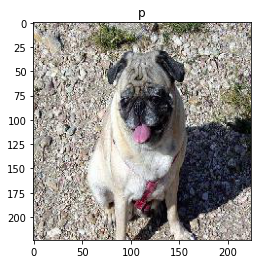

In [39]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(mpimg.imread(path))
plt.title(ans[0])